## Description:

This file contains:
* Trying out diff models on:
    * Scaled, Normalized feature values
    * Feature selected
    * Balanced dataset

In [1]:
"""Helper"""
import pandas as pd
import numpy as np
import time
import joblib
from joblib import parallel_backend

"""Visualization"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

'''Modeling'''
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

'''GCS Utils'''
from gcs_utils import *

'''Modeling Helpers'''
from sklearn.model_selection import (StratifiedKFold, 
                                     cross_val_score)

from sklearn.metrics import (f1_score, 
                             auc, 
                             classification_report, 
                             accuracy_score, 
                             confusion_matrix, 
                             plot_confusion_matrix, 
                             precision_recall_curve, 
                             recall_score,
                             precision_score,
                             roc_curve, 
                             roc_auc_score)

SEED = 42
stkf = StratifiedKFold(3)

In [2]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data'

file_name = 'train_transformed_11232021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 

 
file_name = 'val_transformed_11232021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 

In [2]:
def benchmark(clf, X_train, y_train, X_test, y_test, encoder_labels):

    print('_' * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
        
    print("classification report:")
    print(classification_report(y_test, pred, target_names = encoder_labels))  

    print()
    clf_descr = str(clf).split('(')[0]

    return clf, pred

In [3]:
# read the train set
train_set = pd.read_csv("./train_transformed_11232021.csv")

print("Any NAs?: ", train_set.columns[train_set.isna().any()])

# divide into X_train and y_train

X_train = train_set.iloc[:, :-1]
y_train = train_set["subscription_status"]

print("Shape of X_train:")
print(X_train.shape)
print()
print("Distribution of DMs in train set:")
print(y_train.value_counts())

Any NAs?:  Index([], dtype='object')
Shape of X_train:
(302936, 51)

Distribution of DMs in train set:
0    159440
1    143496
Name: subscription_status, dtype: int64


In [4]:
# read the downloaded test set 
val_set = pd.read_csv("./val_transformed_11232021.csv")

print("Any NAs?: ", val_set.columns[val_set.isna().any()])

# divide into X_test and y_test

X_val = val_set.iloc[:, :-1]
y_val = val_set["subscription_status"]

print("Shape of X_test:")
print(X_val.shape)
print()
print("Distribution of DMs in test set:")
print(y_val.value_counts())

Any NAs?:  Index([], dtype='object')
Shape of X_test:
(76191, 51)

Distribution of DMs in test set:
0    61499
1    14692
Name: subscription_status, dtype: int64


* **Modeling on:**
    * Scaled, Normalized feature values
    * Feature selected
    * Balanced dataset

In [12]:
results = []

for clf, name in ((GaussianNB(), "Gaussian Naive-Bayes"), 
                  (LogisticRegression(random_state= SEED), "Logistic Classifier"),
                  (KNeighborsClassifier(n_neighbors=10), "kNN")
                  
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, y_train, X_val, y_val, 
                              ['non_subscriber', 'subscriber'])) # kNN 10mins

Gaussian Naive-Bayes
________________________________________________________________________________
Training: 
GaussianNB()
classification report:
                precision    recall  f1-score   support

non_subscriber       0.99      0.93      0.96     61499
    subscriber       0.76      0.96      0.85     14692

      accuracy                           0.93     76191
     macro avg       0.88      0.95      0.90     76191
  weighted avg       0.95      0.93      0.94     76191


Logistic Classifier
________________________________________________________________________________
Training: 
LogisticRegression(random_state=1)
classification report:
                precision    recall  f1-score   support

non_subscriber       0.99      0.98      0.99     61499
    subscriber       0.94      0.97      0.95     14692

      accuracy                           0.98     76191
     macro avg       0.97      0.98      0.97     76191
  weighted avg       0.98      0.98      0.98     76191


k

* Even linear models are learning very well
* Suggests results may not be too-good-to-be-true

In [7]:
results = []

for clf, name in ((RandomForestClassifier(random_state=SEED), "Random Forest"),
                  (XGBClassifier(random_state= SEED), "XGB")
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, y_train,  X_val, y_val, 
                              ['non_subscriber', 'subscriber'])) 

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=42)
classification report:
                precision    recall  f1-score   support

non_subscriber       1.00      0.99      0.99     61499
    subscriber       0.97      0.98      0.97     14692

      accuracy                           0.99     76191
     macro avg       0.98      0.99      0.98     76191
  weighted avg       0.99      0.99      0.99     76191


XGB
________________________________________________________________________________
Training: 
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_const

* Cross-val using LGBM

In [5]:
from sklearn.pipeline import Pipeline

scoring='f1_weighted'
stkf = StratifiedKFold(5)

model = lgb.LGBMClassifier(random_state=SEED)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=stkf,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.9887258  0.98910535 0.98946843 0.98895725 0.98948541]
LGBM base score is 0.9891484482652111


* **Precision** - imp if we dont want a lot of false positives
* **Recall** - imp if we dont want to miss out on subscribers
    * We'll give a bit more importance to recall

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61499
    subscriber       0.97      0.98      0.98     14692

      accuracy                           0.99     76191
     macro avg       0.98      0.99      0.99     76191
  weighted avg       0.99      0.99      0.99     76191



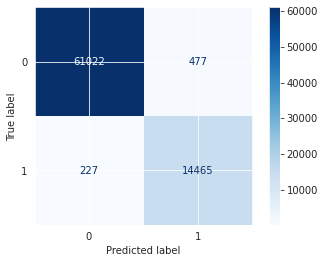

In [6]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))                           
                             
plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

In [7]:
# calculate the f2-measure
from sklearn.metrics import fbeta_score

p = precision_score(y_val, 
                    y_pred)

r = recall_score(y_val, 
                 y_pred)

f = fbeta_score(y_val, 
                y_pred, 
                beta=2.0)

print('Result: precision=%.3f, recall=%.3f, f2-beta=%.3f' % (p, r, f))

Result: precision=0.968, recall=0.985, f2-beta=0.981


In [8]:
beta_values=np.arange(0.5, 2.1, 0.1000)

for beta in beta_values:
    value=fbeta_score(y_val, y_pred, beta=beta,pos_label=1)
    print("F-beta of lgbm on val set:","beta: ",round(beta,1)," F-beta Score: ",value)

F-beta of lgbm on val set: beta:  0.5  F-beta Score:  0.9713268869191511
F-beta of lgbm on val set: beta:  0.6  F-beta Score:  0.9723831404292
F-beta of lgbm on val set: beta:  0.7  F-beta Score:  0.973432641948812
F-beta of lgbm on val set: beta:  0.8  F-beta Score:  0.9744389785449754
F-beta of lgbm on val set: beta:  0.9  F-beta Score:  0.9753797333484338
F-beta of lgbm on val set: beta:  1.0  F-beta Score:  0.9762435040831479
F-beta of lgbm on val set: beta:  1.1  F-beta Score:  0.9770267230492568
F-beta of lgbm on val set: beta:  1.2  F-beta Score:  0.977730918310134
F-beta of lgbm on val set: beta:  1.3  F-beta Score:  0.9783606242463193
F-beta of lgbm on val set: beta:  1.4  F-beta Score:  0.9789219156108421
F-beta of lgbm on val set: beta:  1.5  F-beta Score:  0.9794214462801307
F-beta of lgbm on val set: beta:  1.6  F-beta Score:  0.9798658586522845
F-beta of lgbm on val set: beta:  1.7  F-beta Score:  0.9802614478828916
F-beta of lgbm on val set: beta:  1.8  F-beta Score:  0.

In [8]:
# predicted subscriber rate = 20%

round((14465+477)/(76191), 3)*100

19.6

<AxesSubplot:ylabel='feature'>

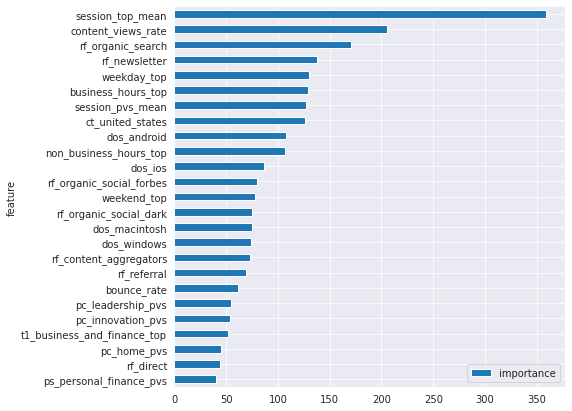

In [9]:
feature_importance = (
    pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'importance': model.feature_importances_, #.steps[0][1]
    })
    .sort_values('importance', ascending=False)
)

feature_importance[:25].sort_values('importance') .plot(kind='barh', x='feature', y='importance', figsize=(7,7))

* Feature importance using Shap

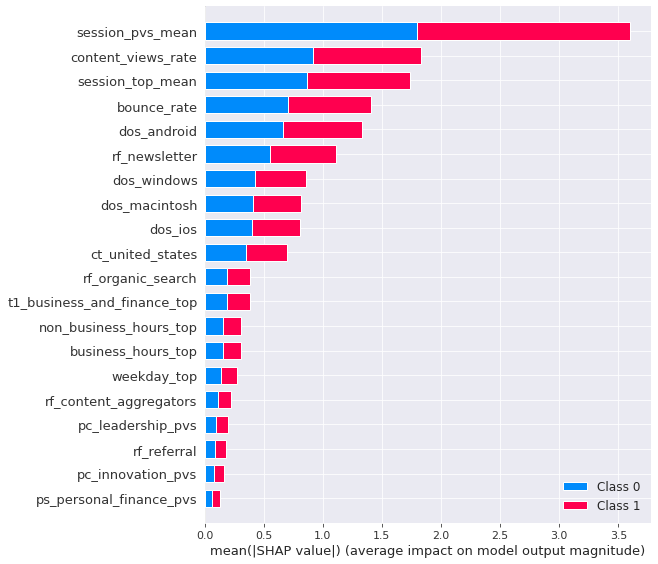

In [19]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)

shap_vals = explainer.shap_values(X_val) 

# SHAP values feat imp
shap.summary_plot(shap_vals, X_val)

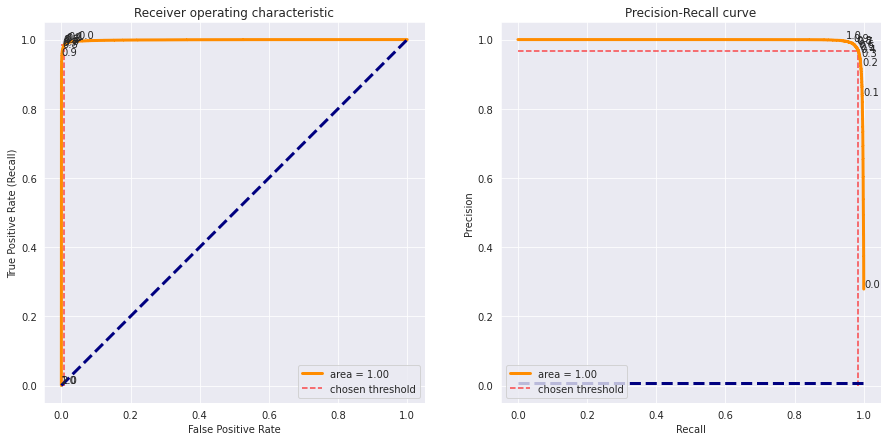

In [18]:
predicted_prob = model.predict_proba(X_val)[:, 1]
predicted = model.predict(X_val)
classes = np.unique(y_val)
recall = recall_score(y_val, predicted) #= true 1s / all 1s in test (got and missed)
precision = precision_score(y_val, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
cm = confusion_matrix(y_val, predicted, labels=classes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
## plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val.values, predicted_prob)
roc_auc = auc(fpr, tpr)     
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), 
              textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
            
## plot P-R curve
precisions, recalls, thresholds = precision_recall_curve(y_val.values, predicted_prob)
roc_auc = auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_val), (cm[1,0]+cm[1,0])/len(y_val)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
         ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), 
               xytext=(recalls[i],precisions[i]), 
               textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
    else:
         next
plt.show()

In [ ]:
# tried to question the results - but couldn't find if theres anything fishy

In [ ]:
# exlcude non-active subscribers -- DONE
# try without desktop/mobile features -- DONE
# shuffle train, val = true -- DONE
# predict on test set -- DONE
# shap feature importance on whole train and val sets --DONE

# when predicting on new people - see if all deskptop by any chance?

* Next Steps:
    * Finalize filtering criteria for prediction pipeline. Generate model results on its sample + EDA + gauge run-time -- make sure no leakage
    
    * HP-tune. Predict on test set - not now
    
    * Do we want an improvement over 98% f1? If so, Round 2 - 
        * more feature eng (listed in proj outline doc)
    * Better - maybe make pipelines efficient:
        * category encoders (how to aggregate encoding at user level? - research)
        * optuna auto-ml w/ diff imputers etc.

**Check the misclassified ones**

In [8]:
orig_val = pd.read_csv("./val_set_11222021.csv")

orig_val["predicted"]= y_pred

In [9]:
# true positives
m = (y_pred ==1) & (y_val == 1)

tp = orig_val[m]
print(tp.shape)

# true neg
m = (y_pred ==0) & (y_val == 0)

tn = orig_val[m]
print(tn.shape)

# false positives
m = (y_pred ==1) & (y_val == 0)

fp = orig_val[m]
print(fp.shape)

# false neg
m = (y_pred ==0) & (y_val == 1)
fn = orig_val[m]
print(fn.shape)

(14465, 620)
(61022, 620)
(477, 620)
(227, 620)


In [23]:
top10_feat = feature_importance[:5].feature.to_list()

In [24]:
tp[top10_feat].describe()[1:]

,session_top_mean,content_views_rate,rf_organic_search,rf_newsletter,weekday_top
mean,208.2,0.7,45.7,5.9,129.8
std,248.9,0.3,186.3,42.9,120.6
min,0.0,0.0,0.0,0.0,0.0
25%,82.0,0.5,0.0,0.0,54.7
50%,144.0,0.8,10.0,0.0,106.9
75%,249.1,0.9,36.0,0.0,173.6
max,9680.0,1.0,10068.0,2398.0,5003.0


In [25]:
tn[top10_feat].describe()[1:]

,session_top_mean,content_views_rate,rf_organic_search,rf_newsletter,weekday_top
mean,79.6,1.0,1.6,0.0,55.5
std,152.2,0.0,3.4,0.0,114.9
min,0.0,0.1,0.0,0.0,0.0
25%,6.7,1.0,0.0,0.0,0.0
50%,36.3,1.0,1.0,0.0,17.0
75%,89.3,1.0,2.0,0.0,66.0
max,2703.0,1.0,139.0,0.0,2348.0


In [26]:
fp[top10_feat].describe()[1:]

,session_top_mean,content_views_rate,rf_organic_search,rf_newsletter,weekday_top
mean,135.9,0.8,4.9,0.0,105.0
std,166.7,0.2,11.5,0.4,138.6
min,0.0,0.1,0.0,0.0,0.0
25%,43.1,0.7,0.0,0.0,26.3
50%,86.8,0.9,0.0,0.0,64.9
75%,164.0,1.0,5.0,0.0,126.0
max,1671.5,1.0,114.0,6.0,1671.5


In [27]:
fn[top10_feat].describe()[1:]

,session_top_mean,content_views_rate,rf_organic_search,rf_newsletter,weekday_top
mean,177.3,0.9,4.3,0.1,100.3
std,308.9,0.2,7.5,1.6,200.8
min,0.0,0.2,0.0,0.0,0.0
25%,36.8,1.0,0.0,0.0,13.1
50%,88.2,1.0,1.0,0.0,46.0
75%,186.4,1.0,4.5,0.0,98.8
max,3240.0,1.0,56.0,24.0,1737.0


In [22]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)
c= explainer.shap_values(X_val[m])
shap.force_plot(explainer.expected_value[1], c[1], X_val[m])

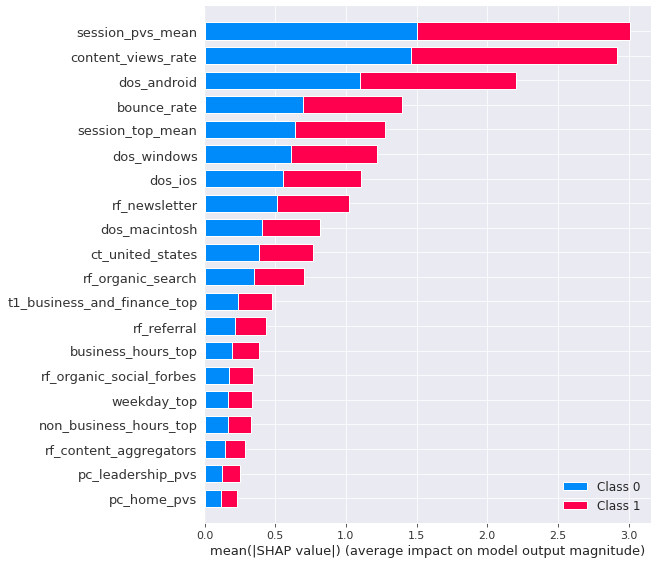

In [46]:
# false positive
shap.summary_plot(c, X_val[m])

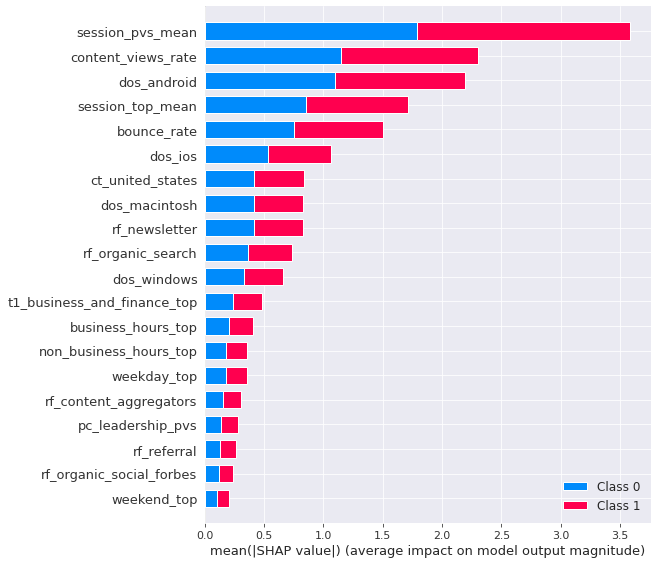

In [51]:
# false neg
shap.summary_plot(c, X_val[m])